In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pybedtools
import tabix
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
model_dict={}
peak_dict={}
model_dict['IDR']='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/single_cell/microglia.new.model.'
model_dict['OVERLAP']='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/single_cell/microglia.new.model.'
peak_dict['IDR']='/mnt/lab_data2/annashch/alzheimers_parkinsons/pseudobulk/rGREAT/idr/Cluster24.bed'
peak_dict['OVERLAP']='/mnt/lab_data2/annashch/alzheimers_parkinsons/pseudobulk/rGREAT/overlap/Cluster24.bed'

## Get GWAS Tag SNPs

In [26]:
gwas = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/GWAS_Kunkle2019.txt.gz', sep='\t', keep_default_na=False)
new_cols = {}
for i in gwas.columns:
    new_cols[i] = i.upper()
gwas.rename(columns=new_cols, inplace=True)
gwas.rename(columns={'SNP_POS':'END', 'EFFECT_ALLELE':'ALT', 'NON_EFFECT_ALLELE': 'REF'}, inplace=True)
gwas['CHR'] = gwas['CHR'].apply(lambda x: 'chr' + str(x))
gwas['START'] = gwas['END'] - 1
gwas = gwas[['CHR','START','END','RSID','PVALUE','REF','ALT','EFFECT_DIRECTION','BETA','SE','MARKERNAME']]
display(gwas.head())
print(gwas.shape)
gwas.to_csv('/mnt/lab_data3/soumyak/adpd/gwas/all_snps_kunkle.csv', sep='\t', index=False)
new_gwas = gwas.loc[gwas['PVALUE'] < 5e-8]
display(new_gwas.head())
print(new_gwas.shape)
new_gwas.to_csv('/mnt/lab_data3/soumyak/adpd/gwas/tag_snps_kunkle.csv', sep='\t', index=False)

,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME
0,chr1,662621,662622,rs61769339,0.02869,G,A,-,-0.1000,0.0457,rs61769339
1,chr1,693624,693625,rs190214723,0.81200,C,T,-,-0.0163,0.0685,
2,chr1,693730,693731,rs12238997,0.01598,G,A,+,0.0996,0.0413,rs61769350
3,chr1,705881,705882,rs72631875,0.75740,G,A,-,-0.0184,0.0595,rs72631875
4,chr1,718504,718505,rs181440659,0.23200,G,A,-,-0.1628,0.1362,rs181440659


(11596256, 11)


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME
706229,chr1,207679306,207679307,rs4844600,1.598000e-13,G,A,+,0.1324,0.0179,rs4844600
706246,chr1,207684191,207684192,rs12037841,1.769000e-15,G,T,+,0.1473,0.0185,rs12037841
706250,chr1,207685785,207685786,rs4266886,2.090000e-14,C,T,+,0.1365,0.0179,rs4266886
706251,chr1,207685964,207685965,rs4562624,1.826000e-15,C,A,+,0.1472,0.0185,rs4562624
706281,chr1,207692048,207692049,rs6656401,2.169000e-15,G,A,+,0.1465,0.0185,rs6656401


(1547, 11)


## Get GWAS LD SNPs

In [76]:
basefilename='/mnt/lab_data3/soumyak/adpd/gwas/all_snps_kunkle.csv.'
for fold in [1,7,3,0,9,6]:
    print(fold)
    gwas = pd.read_csv('/mnt/lab_data3/soumyak/adpd/gwas/tag_snps_kunkle.csv.'+str(fold),
                       sep='\t', keep_default_na=False)
    gwas['START'] = gwas['START'] - 250000
    gwas['END'] = gwas['END'] + 250000
    gwas_bed = pybedtools.BedTool.from_dataframe(gwas)
    orig_gwas = pybedtools.BedTool(basefilename+str(fold))
    ld_buddies = orig_gwas.intersect(gwas_bed, u=True)
    if ld_buddies.count() != 0:
        ld_df = pybedtools.BedTool.to_dataframe(ld_buddies)
        ld_df.columns = gwas.columns
        #new_ld_df = format_snps(ld_df, 'ALT')
        ld_df.to_csv('/mnt/lab_data3/soumyak/adpd/gwas/ld_buddies_kunkle.csv.'+str(fold), sep='\t', index=False)

1
7
3
0
9
6


## Constant Addresses

In [5]:
ref_fasta='/mnt/data/pipeline_genome_data/hg19/male.hg19.fa'
snp_prefix='/mnt/lab_data3/soumyak/adpd/gwas/'

## Get Predictions from all Folds

In [9]:
def get_preds_all_folds(task, ref_fasta=ref_fasta, snp_prefix=snp_prefix):
    
    basefilename='/mnt/lab_data3/soumyak/adpd/gwas/ld_buddies_kunkle.csv.'

    model_prefix=model_dict[task]
    
    for fold in [1]:#[1,7,3,0,9,6]:
        print(fold)
        #load the model
        custom_objects={"recall":recall,
                        "sensitivity":recall,
                        "specificity":specificity,
                        "fpr":fpr,
                        "fnr":fnr,
                        "precision":precision,
                        "f1":f1,
                        "ambig_binary_crossentropy":ambig_binary_crossentropy,
                        "ambig_mean_squared_error":ambig_mean_squared_error}
        model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
        print("loaded model")
        #get reference allele predictions 
        snp_file=basefilename+str(fold)
        snp_ref_generator=SNPGenerator(data_path=snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="REF")
        snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                    max_queue_size=5000, 
                                                    workers=20, 
                                                    use_multiprocessing=True,
                                                    verbose=1)
        print("got snp ref predictions")
        #get alternate allele predictions 
        snp_alt_generator=SNPGenerator(data_path=snp_file,
                                       ref_fasta=ref_fasta,
                                       allele_col="ALT")
        snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                    max_queue_size=5000,
                                                    workers=20, 
                                                    use_multiprocessing=True,
                                                    verbose=1)
        print("got snp alt predictions")
        snp_ref_generator.data['ref_pred']=snp_ref_predictions
        snp_ref_generator.data['alt_pred']=snp_alt_predictions
        snp_ref_generator.data.to_csv('microglia.'+task+'.GWAS_SNP_predictions.txt'+'.'+str(fold),sep='\t')

In [10]:
get_preds_all_folds('IDR')

1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(11638, 8)
91/91 [==============================] - 3s 33ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(11638, 8)
91/91 [==============================] - 3s 32ms/step
got snp alt predictions


## Get Results from all Folds

In [11]:
def get_results_all_folds(task):
    for fold in [1]:#[1,7,3,0,9,6]:
        print("TASK: Microglia ",task)
        print("FOLD: ",fold)
        snp_predictions=pd.read_csv('microglia.'+task+'.GWAS_SNP_predictions.txt'+'.'+str(fold),sep='\t')
        print("All SNPs:")
        display(snp_predictions.shape)
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        peak_bed = pybedtools.BedTool(peak_dict[task])
        pos_snps_bed = snp_bed.intersect(peak_bed, u=True)
        if pos_snps_bed.count() > 0:
            pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
            pos_snps.columns = snp_predictions.columns
            print("SNPs in Peaks:")
            display(pos_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(pos_snps,
                aes(x="ref_pred",y="alt_pred",label='RSID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle('MICROGLIA '+task+' FOLD '+str(fold)+' IN PEAK')))
            pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
            pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])
            print("Negative SNPs in Peaks:")
            display(pos_snp_predictions_sorted.head(10))
            print("Positive SNPs in Peaks:")
            display(pos_snp_predictions_sorted.tail(10))
        snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
        peak_bed = pybedtools.BedTool(peak_dict[task])
        neg_snps_bed = snp_bed.intersect(peak_bed, v=True)
        if neg_snps_bed.count() > 0:
            neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
            neg_snps.columns = snp_predictions.columns
            print("SNPs NOT in Peaks:")
            display(neg_snps.shape)
            plotnine.options.figure_size = (6,6)
            display((ggplot(neg_snps,
                aes(x="ref_pred",y="alt_pred",label='RSID'))+
            geom_point(alpha=0.3,color='red')+
            theme_bw(20)+
            xlab("Reference Allele Prediction")+
            ylab("Alternate Allele Prediction")+
            ggtitle('MICROGLIA '+task+' FOLD '+str(fold)+' OUTSIDE PEAK')))
            neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
            neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])
            print("Negative SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.head(10))
            print("Positive SNPs OUTSIDE Peaks:")
            display(neg_snp_predictions_sorted.tail(10))

TASK: Microglia  IDR
FOLD:  1
All SNPs:


(11638, 13)

SNPs in Peaks:


(625, 13)

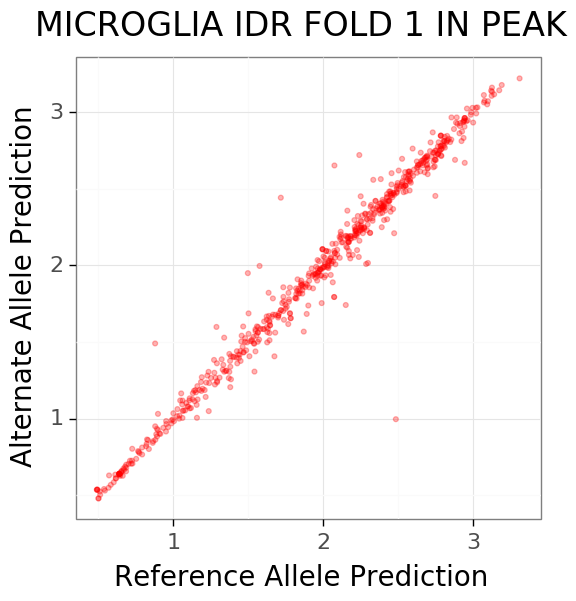

<ggplot: (8751985739647)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
338,chr19,45430416,45430417,rs11878790,0.000143,C,T,+,0.3011,0.0792,rs11878790,2.483054,0.997001,-1.486053
213,chr19,1207279,1207280,rs3764641,0.252900,C,T,+,0.0333,0.0291,rs3764641,2.149111,1.741091,-0.408020
508,chr2,127753267,127753268,rs6716819,0.590100,C,T,+,0.0093,0.0173,rs6716819,1.869020,1.567813,-0.301206
105,chr19,1041163,1041164,rs3752228,0.034680,C,T,-,-0.0839,0.0397,rs3752228,2.746382,2.452073,-0.294309
110,chr19,1065017,1065018,rs4147934,0.000090,G,T,-,-0.0677,0.0173,rs4147934,2.296942,2.015266,-0.281676
539,chr2,127867016,127867017,rs386650195,0.326800,C,T,+,0.0333,0.0340,rs9653201,2.071663,1.793284,-0.278379
540,chr2,127867016,127867017,rs9653201,0.326800,C,T,+,0.0333,0.0340,rs9653201,2.071663,1.793284,-0.278379
509,chr2,127753416,127753417,rs143479515,0.507900,C,T,+,0.0630,0.0952,rs143479515,2.284838,2.008322,-0.276516
489,chr2,127707602,127707603,rs11884286,0.757500,G,A,+,0.0070,0.0228,rs11884286,2.942445,2.667642,-0.274803
599,chr2,127937550,127937551,rs13035268,0.281900,G,A,-,-0.0154,0.0143,rs13035268,1.673320,1.406767,-0.266554


Positive SNPs in Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
490,chr2,127729011,127729012,rs34840927,7.049000e-01,G,A,-,-0.0104,0.0276,rs34840927,2.159706,2.355994,0.196289
160,chr19,1101920,1101921,rs36207556,9.703000e-01,G,A,-,-0.0026,0.0697,rs36207556,2.248622,2.449599,0.200977
310,chr19,45359775,45359776,rs75765623,2.973000e-02,C,T,-,-0.1398,0.0643,rs75765623,2.332578,2.556830,0.224252
329,chr19,45414398,45414399,rs72654473,5.803000e-01,C,A,-,-0.0138,0.0249,rs72654473,1.286644,1.598267,0.311623
538,chr2,127867015,127867016,rs9653207,3.390000e-01,G,A,-,-0.0325,0.0340,rs9653207,1.574243,1.995688,0.421444
543,chr2,127886232,127886233,rs13025765,3.250000e-15,C,T,+,0.1251,0.0159,rs13025765,1.496044,1.948915,0.452871
369,chr19,45579798,45579799,rs139836843,6.533000e-01,G,A,-,-0.1856,0.4132,rs139836843,2.239370,2.718476,0.479106
100,chr19,1038289,1038290,rs775472045,1.906000e-01,AG,A,-,-0.0358,0.0274,chr19:1038290:D,2.073527,2.650420,0.576893
581,chr2,127921719,127921720,rs1983088,3.697000e-03,C,T,-,-0.0481,0.0166,rs1983088,0.877708,1.490658,0.612950
319,chr19,45373564,45373565,rs395908,6.302000e-01,G,A,-,-0.0097,0.0202,rs395908,1.715886,2.440500,0.724614


SNPs NOT in Peaks:


(11011, 13)

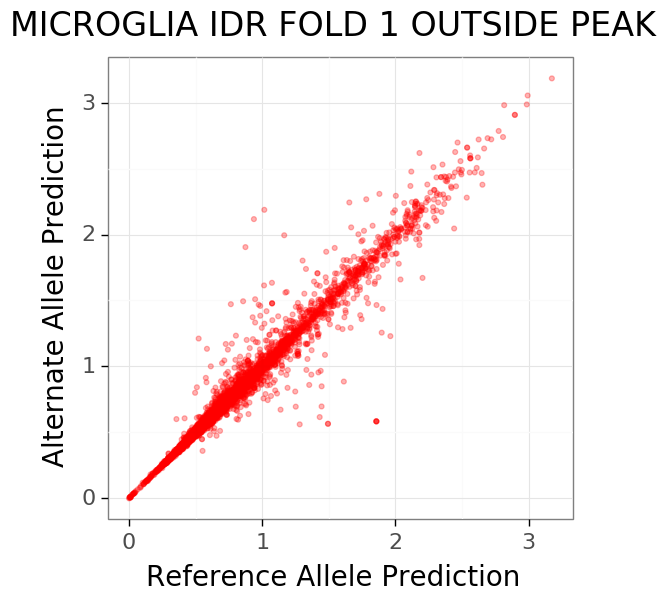

<ggplot: (-9223363284902423864)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
7512,chr19,45988106,45988107,rs73049949,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7513,chr19,45988106,45988107,rs756185546,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7514,chr19,45988106,45988107,rs796467167,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7511,chr19,45988106,45988107,rs147035897,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7578,chr19,46006211,46006212,rs201581883,3.806000e-01,G,A,-,-0.0137,0.0156,rs8110916,1.493148,0.563351,-0.929797
7579,chr19,46006211,46006212,rs8110916,3.806000e-01,G,A,-,-0.0137,0.0156,rs8110916,1.493148,0.563351,-0.929797
7510,chr19,45988105,45988106,rs200596150,1.233000e-01,TC,T,-,-0.0444,0.0288,chr19:45988106:D,1.430989,0.614244,-0.816745
10159,chr2,127909484,127909485,rs113749303,2.270000e-02,C,CT,-,-0.0345,0.0151,chr2:127909485:I,1.445304,0.695055,-0.750249
4098,chr19,45080368,45080369,rs55848260,4.404000e-11,G,A,+,0.1084,0.0165,rs55848260,1.961800,1.228938,-0.732862
4985,chr19,45309971,45309972,rs28399594,5.306000e-04,G,T,-,-0.3812,0.1100,rs28399594,1.612389,0.884067,-0.728321


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
65,chr19,804141,804142,rs61757783,5.782000e-01,G,A,-,-0.0524,0.0942,rs61757783,0.946152,1.509127,0.562974
6285,chr19,45672204,45672205,rs188990233,2.607000e-02,G,C,-,-0.1265,0.0568,rs188990233,1.653470,2.243722,0.590252
4750,chr19,45240125,45240126,rs184293662,1.802000e-30,C,T,+,1.4160,0.1234,rs184293662,1.013192,1.614087,0.600895
3523,chr19,44974755,44974756,rs8103919,7.238000e-01,C,T,+,0.0110,0.0310,rs8103919,0.856052,1.493801,0.637749
6213,chr19,45649837,45649838,rs78073763,1.032000e-06,G,T,+,0.1628,0.0333,rs78073763,0.522284,1.210454,0.688170
4457,chr19,45181011,45181012,rs141846480,7.653000e-01,G,A,+,0.0111,0.0373,rs141846480,0.763908,1.471637,0.707729
3683,chr19,44996548,44996549,rs28394449,2.048000e-01,T,A,+,0.1846,0.1456,rs28394449,1.164702,1.994840,0.830138
9817,chr2,127843192,127843193,rs13425613,3.452000e-01,C,A,+,0.0184,0.0194,rs13425613,0.873431,1.904893,1.031462
6121,chr19,45623769,45623770,rs117789739,3.553000e-01,C,T,-,-0.0538,0.0582,rs117789739,1.015149,2.187992,1.172843
9172,chr2,127713082,127713083,rs11884053,7.230000e-01,G,A,+,0.0081,0.0228,rs11884053,0.937039,2.117537,1.180498


In [12]:
get_results_all_folds('IDR')

In [13]:
get_preds_all_folds('OVERLAP')

1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(11638, 8)
91/91 [==============================] - 3s 36ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(11638, 8)
91/91 [==============================] - 3s 32ms/step
got snp alt predictions


TASK: Microglia  OVERLAP
FOLD:  1
All SNPs:


(11638, 13)

SNPs in Peaks:


(730, 13)

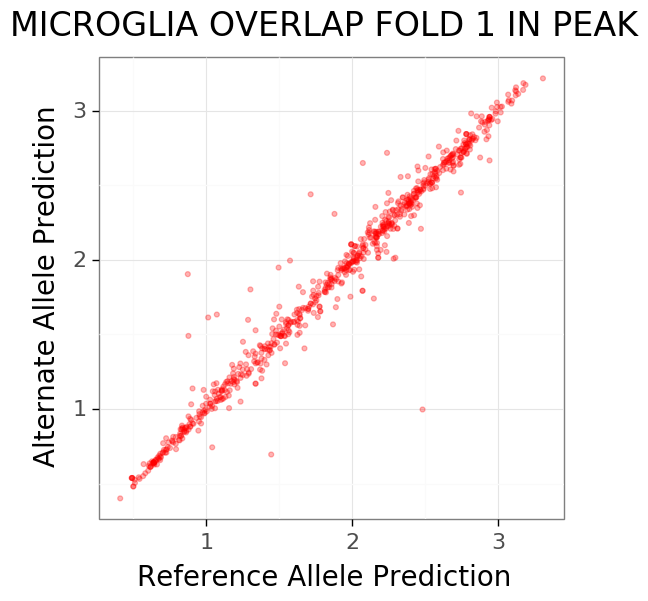

<ggplot: (8751860226389)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
365,chr19,45430416,45430417,rs11878790,1.432000e-04,C,T,+,0.3011,0.0792,rs11878790,2.483054,0.997001,-1.486053
665,chr2,127909484,127909485,rs113749303,2.270000e-02,C,CT,-,-0.0345,0.0151,chr2:127909485:I,1.445304,0.695055,-0.750249
230,chr19,1207279,1207280,rs3764641,2.529000e-01,C,T,+,0.0333,0.0291,rs3764641,2.149111,1.741091,-0.408020
565,chr2,127753267,127753268,rs6716819,5.901000e-01,C,T,+,0.0093,0.0173,rs6716819,1.869020,1.567813,-0.301206
620,chr2,127878431,127878432,rs4663099,6.519000e-12,C,A,+,0.1192,0.0174,rs4663099,1.040795,0.743238,-0.297556
120,chr19,1041163,1041164,rs3752228,3.468000e-02,C,T,-,-0.0839,0.0397,rs3752228,2.746382,2.452073,-0.294309
125,chr19,1065017,1065018,rs4147934,8.992000e-05,G,T,-,-0.0677,0.0173,rs4147934,2.296942,2.015266,-0.281676
618,chr2,127867016,127867017,rs9653201,3.268000e-01,C,T,+,0.0333,0.0340,rs9653201,2.071663,1.793284,-0.278379
617,chr2,127867016,127867017,rs386650195,3.268000e-01,C,T,+,0.0333,0.0340,rs9653201,2.071663,1.793284,-0.278379
566,chr2,127753416,127753417,rs143479515,5.079000e-01,C,T,+,0.0630,0.0952,rs143479515,2.284838,2.008322,-0.276516


Positive SNPs in Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
454,chr19,45931950,45931951,rs75007915,1.394000e-02,G,T,+,0.1827,0.0743,rs75007915,1.879343,2.308995,0.429652
623,chr2,127886232,127886233,rs13025765,3.250000e-15,C,T,+,0.1251,0.0159,rs13025765,1.496044,1.948915,0.452871
399,chr19,45579798,45579799,rs139836843,6.533000e-01,G,A,-,-0.1856,0.4132,rs139836843,2.239370,2.718476,0.479106
376,chr19,45449165,45449166,rs12721063,1.363000e-01,G,A,-,-0.1580,0.1060,rs12721063,1.302812,1.802352,0.499541
440,chr19,45912001,45912002,rs735482,8.777000e-01,C,A,+,0.0032,0.0207,rs735482,1.072480,1.633941,0.561461
115,chr19,1038289,1038290,rs775472045,1.906000e-01,AG,A,-,-0.0358,0.0274,chr19:1038290:D,2.073527,2.650420,0.576893
295,chr19,45240125,45240126,rs184293662,1.802000e-30,C,T,+,1.4160,0.1234,rs184293662,1.013192,1.614087,0.600895
678,chr2,127921719,127921720,rs1983088,3.697000e-03,C,T,-,-0.0481,0.0166,rs1983088,0.877708,1.490658,0.612950
346,chr19,45373564,45373565,rs395908,6.302000e-01,G,A,-,-0.0097,0.0202,rs395908,1.715886,2.440500,0.724614
597,chr2,127843192,127843193,rs13425613,3.452000e-01,C,A,+,0.0184,0.0194,rs13425613,0.873431,1.904893,1.031462


SNPs NOT in Peaks:


(10906, 13)

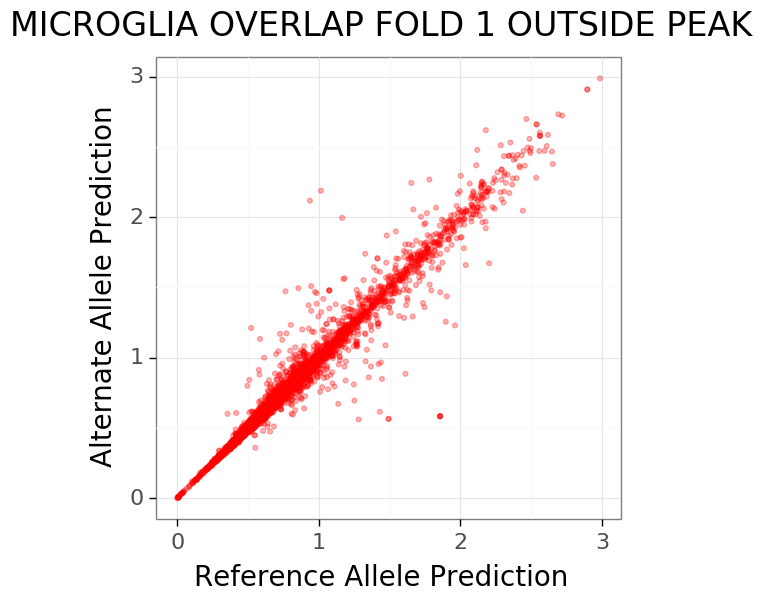

<ggplot: (8751952210829)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
7474,chr19,45988106,45988107,rs796467167,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7471,chr19,45988106,45988107,rs147035897,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7472,chr19,45988106,45988107,rs73049949,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7473,chr19,45988106,45988107,rs756185546,7.583000e-02,C,T,-,-0.0497,0.0280,rs73049949,1.856421,0.581990,-1.274431
7538,chr19,46006211,46006212,rs8110916,3.806000e-01,G,A,-,-0.0137,0.0156,rs8110916,1.493148,0.563351,-0.929797
7537,chr19,46006211,46006212,rs201581883,3.806000e-01,G,A,-,-0.0137,0.0156,rs8110916,1.493148,0.563351,-0.929797
7470,chr19,45988105,45988106,rs200596150,1.233000e-01,TC,T,-,-0.0444,0.0288,chr19:45988106:D,1.430989,0.614244,-0.816745
4079,chr19,45080368,45080369,rs55848260,4.404000e-11,G,A,+,0.1084,0.0165,rs55848260,1.961800,1.228938,-0.732862
4959,chr19,45309971,45309972,rs28399594,5.306000e-04,G,T,-,-0.3812,0.1100,rs28399594,1.612389,0.884067,-0.728321
6061,chr19,45615856,45615857,rs6509194,5.450000e-04,C,T,-,-0.0530,0.0153,rs6509194,1.280937,0.559097,-0.721840


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,PVALUE,REF,ALT,EFFECT_DIRECTION,BETA,SE,MARKERNAME,ref_pred,alt_pred,delta
9608,chr2,127814780,127814781,rs3754618,0.200400,G,A,+,0.0233,0.0182,rs3754618,0.972699,1.467796,0.495097
7919,chr19,46113147,46113148,rs73050333,0.789300,C,T,-,-0.0119,0.0444,rs73050333,0.584464,1.132635,0.548171
64,chr19,804141,804142,rs61757783,0.578200,G,A,-,-0.0524,0.0942,rs61757783,0.946152,1.509127,0.562974
6251,chr19,45672204,45672205,rs188990233,0.026070,G,C,-,-0.1265,0.0568,rs188990233,1.653470,2.243722,0.590252
3504,chr19,44974755,44974756,rs8103919,0.723800,C,T,+,0.0110,0.0310,rs8103919,0.856052,1.493801,0.637749
6181,chr19,45649837,45649838,rs78073763,0.000001,G,T,+,0.1628,0.0333,rs78073763,0.522284,1.210454,0.688170
4438,chr19,45181011,45181012,rs141846480,0.765300,G,A,+,0.0111,0.0373,rs141846480,0.763908,1.471637,0.707729
3664,chr19,44996548,44996549,rs28394449,0.204800,T,A,+,0.1846,0.1456,rs28394449,1.164702,1.994840,0.830138
6089,chr19,45623769,45623770,rs117789739,0.355300,C,T,-,-0.0538,0.0582,rs117789739,1.015149,2.187992,1.172843
9115,chr2,127713082,127713083,rs11884053,0.723000,G,A,+,0.0081,0.0228,rs11884053,0.937039,2.117537,1.180498


In [14]:
get_results_all_folds('OVERLAP')